In [3]:
import numpy as np
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, warnings
#from mpl_toolkits.basemap import Basemap
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
file_list = check_output(["ls", "../input"]).decode("utf8")
file_list = file_list.strip().split('\n')

air_reserve.csv
air_store_info.csv
air_visit_data.csv
date_info.csv
hpg_store_info.csv
sample_submission.csv
store_id_relation.csv



# Read data and display info

In [5]:
for index, file in enumerate(file_list):
    var_name = file.rstrip('.csv')
    locals()[var_name] = pd.read_csv('../input/' + file)
    print(file)
    
    # convert to datetime
    for col in locals()[var_name].columns:
        if col.endswith('datetime') or col.endswith('date'):
            locals()[var_name][col] = pd.to_datetime(locals()[var_name][col])
    
    print('Shape:', locals()[var_name].shape)
    print('\n')
    print(locals()[var_name].info())
    print('\n')
    print(locals()[var_name].head())
    print('***********************************************************************************')

air_reserve.csv
Shape: (92378, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null datetime64[ns]
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB
None


           air_store_id      visit_datetime    reserve_datetime  \
0  air_877f79706adbfb06 2016-01-01 19:00:00 2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
3  air_877f79706adbfb06 2016-01-01 20:00:00 2016-01-01 16:00:00   
4  air_db80363d35f10926 2016-01-01 20:00:00 2016-01-01 01:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 6  
3                 2  
4                 5  
**************************************************************

In [6]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


# Store Distribution map

NameError: name 'Basemap' is not defined

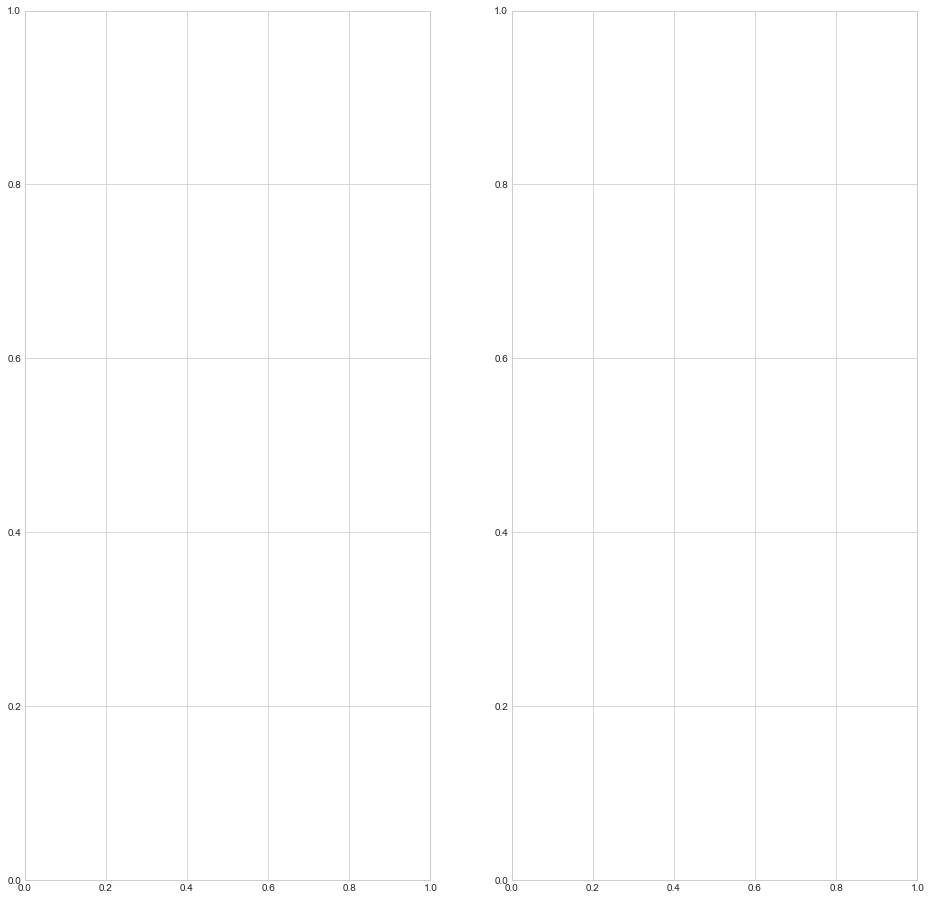

In [7]:
fig,ax = plt.subplots(1,2,figsize = (16,16))

color = ['red','yellow']
title = ['air_store distribution', 'hpg_store distribution']
for i,data in enumerate([air_store_info,hpg_store_info]):
    m = Basemap(resolution = 'h',lon_0 = 0, lat_0 = 0,llcrnrlon=127, urcrnrlon=147,
                      llcrnrlat=29, urcrnrlat=47, ax = ax[i])
    m.bluemarble()
    m.drawcoastlines(color = 'gray')
    m.drawcountries(color = 'gray')
    m.drawstates(color = 'gray')
    m.scatter(data['longitude'], data['latitude'], latlon = True, color = color[i], marker='o')
    ax[i].set_title(title[i])

# Visitors visualization

Aggregated vistors by visit date

[Text(0,0.5,'Dailyvisitors'), Text(0.5,0,'')]

[Text(0,0.5,'Weeklyvisitors'), Text(0.5,0,'')]

[Text(0,0.5,'Monthlyvisitors'), Text(0.5,0,'')]

Text(0.5,0,'visit date')

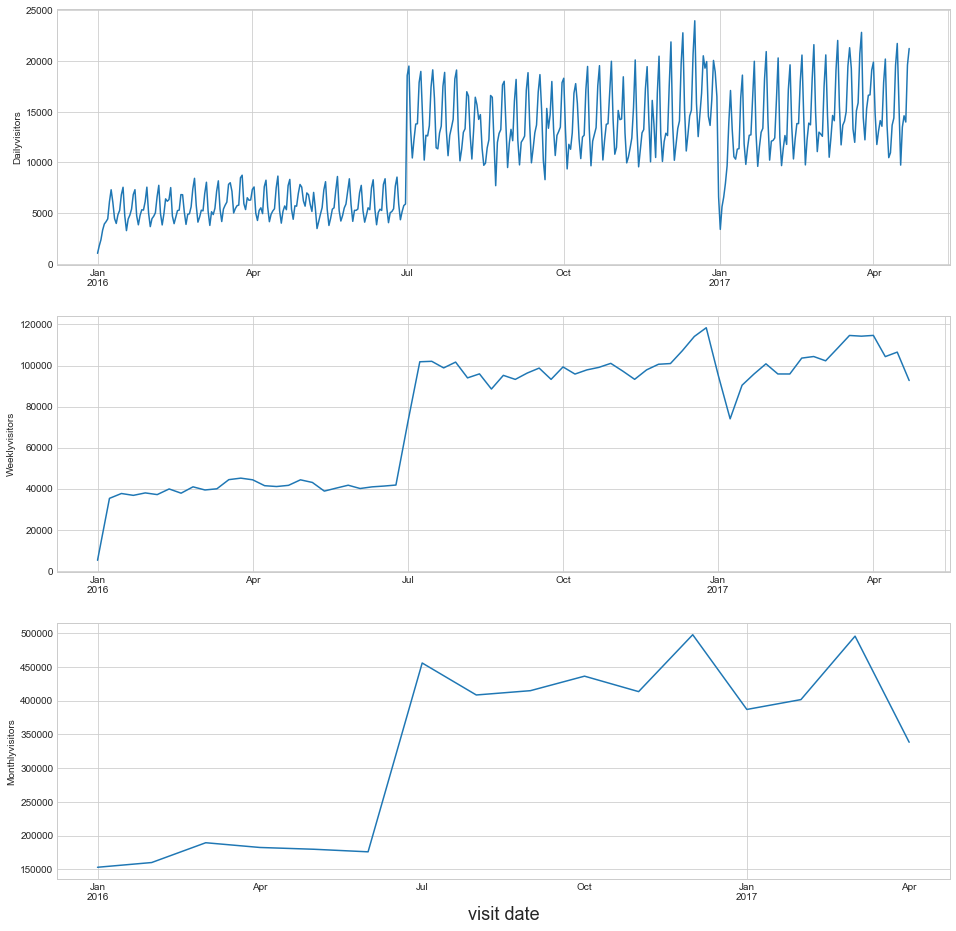

In [8]:
fig,ax = plt.subplots(3,1, figsize = (16,16))
Fre = ["Daily", "Weekly", "Monthly"]

for i,fre in enumerate(["D","W","M"]):
    air_visit_data.groupby('visit_date')['visitors'].sum().resample(fre).sum().plot(ax = ax[i])
    ax[i].set(ylabel = (Fre[i] + 'visitors'), xlabel = "")
plt.xlabel('visit date', fontsize = 18)

Let's get deeper into Reservasion dataset.

In [9]:
# convert hpg_store_id to air_store_id
hpg_reserve = hpg_reserve.merge(store_id_relation, on = 'hpg_store_id', how = 'left')
air = hpg_reserve['air_store_id']
hpg_reserve['hpg_store_id'] = air
hpg_reserve = hpg_reserve[hpg_reserve['hpg_store_id'].notnull()]
hpg_reserve = hpg_reserve.drop('air_store_id', axis = 1)
hpg_reserve.head()

NameError: name 'hpg_reserve' is not defined

In [8]:
# add new feature, combine two dataset
def delta_reservation(df):
    df['delta_reservation'] = df['visit_datetime'] - df['reserve_datetime']
    df['delta_2days'] = df['delta_reservation'].apply(lambda x: int(x.days < 2))
    df['delta_7days'] = df['delta_reservation'].apply(lambda x: int(2 <= x.days < 7))
    df['delta_long'] = df['delta_reservation'].apply(lambda x: int(x.days >= 7))
    return df

air_reserve = delta_reservation(air_reserve)
hpg_reserve = delta_reservation(hpg_reserve)

air_reserve.rename(columns = {'air_store_id':'store_id'}, inplace = True)
hpg_reserve.rename(columns = {'hpg_store_id':'store_id'}, inplace = True)
total_reserve = pd.concat([air_reserve, hpg_reserve])
total_reserve['date'] = total_reserve['visit_datetime'].apply(lambda x:x.date())
total_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors,delta_reservation,delta_2days,delta_7days,delta_long,date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,03:00:00,1,0,0,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,00:00:00,1,0,0,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,00:00:00,1,0,0,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,04:00:00,1,0,0,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,19:00:00,1,0,0,2016-01-01


How many unique stores are reserved? How many unique stores are visited?

In [9]:
num_reserve = total_reserve['store_id'].nunique()
num_visit = air_visit_data['air_store_id'].nunique()
print("{} stores are reserved".format(num_reserve))
print("{} stores are visited".format(num_visit))

333 stores are reserved
829 stores are visited


Text(0,0.5,'Visitors')

Text(0.5,0,'Date')

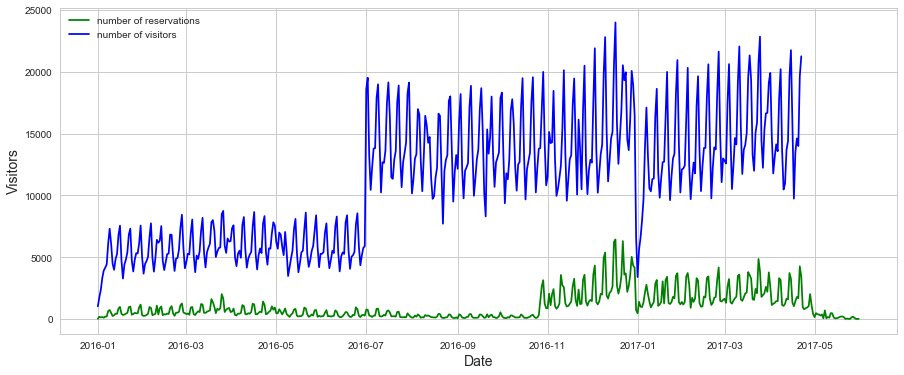

In [10]:
reserve_by_date = total_reserve.groupby('date').sum().reset_index()
visit_by_date = air_visit_data.groupby('visit_date').sum().reset_index()

plt.plot(reserve_by_date['date'], reserve_by_date['reserve_visitors'], color = 'green', label = 'number of reservations')
plt.plot(visit_by_date['visit_date'], visit_by_date['visitors'], color = 'blue', label = 'number of visitors')
plt.legend(loc = 'upper left')
plt.ylabel('Visitors', fontsize = 14)
plt.xlabel('Date', fontsize = 14)

What time do people usually make a reservation and visit?

([<matplotlib.axis.XTick at 0x2605e94de48>,
 <a list of 6 Text xticklabel objects>)

Text(0,0.5,'reserve visitors')

Text(0.5,0,'time')

(0, 86400)

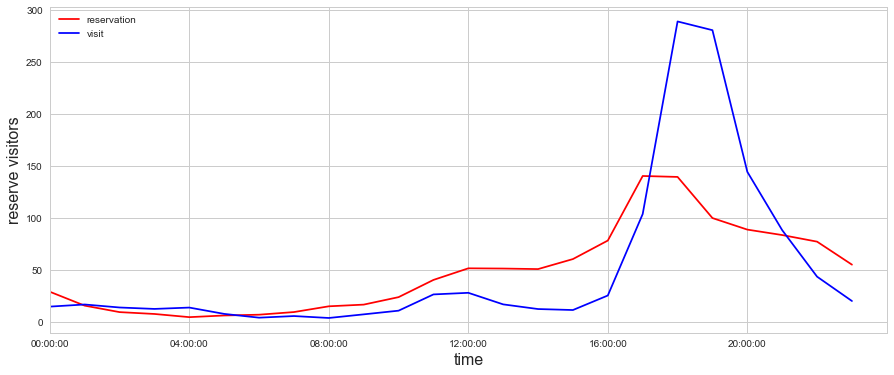

In [11]:
df1 = total_reserve.groupby('reserve_datetime')['reserve_visitors'].sum()
reserve_time = df1.groupby(df1.index.time).mean().reset_index()

df2 = total_reserve.groupby('visit_datetime')['reserve_visitors'].sum()
visit_time = df2.groupby(df2.index.time).mean().reset_index()

hourly_ticks = 4 * 60 * 60 * np.arange(6)
plt.plot(reserve_time['index'], reserve_time['reserve_visitors'],color = 'red', label = 'reservation')
plt.plot(visit_time['index'], visit_time['reserve_visitors'], color = 'blue', label = 'visit')
plt.xticks(hourly_ticks)
plt.legend(loc = 'upper left')
plt.ylabel('reserve visitors', fontsize = 16)
plt.xlabel('time', fontsize = 16)
plt.xlim(0,4 * 60 * 60 * 6)

What day of week do people usually reserve and visit?

Text(0,0.5,'reserve visitors')

Text(0.5,0,'day of week')

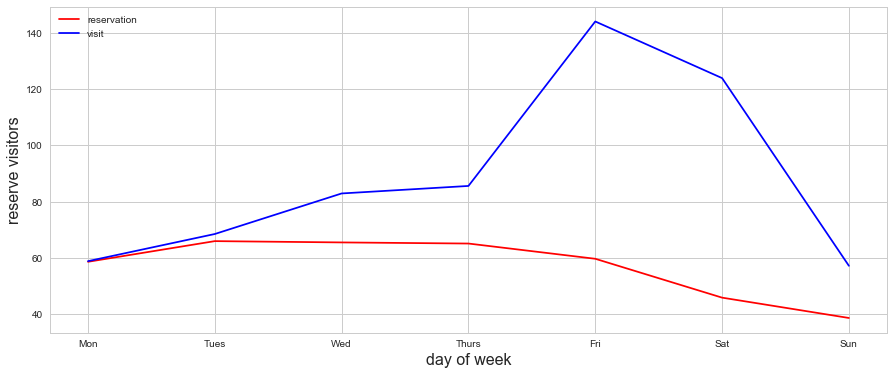

In [13]:
by_weekday_df1 = df1.groupby(df1.index.dayofweek).mean()
by_weekday_df1.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday_df1.plot(color = 'red', label = 'reservation')

by_weekday_df2 = df2.groupby(df2.index.dayofweek).mean()
by_weekday_df2.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday_df2.plot(color = 'blue', label = 'visit')
plt.legend(loc = 'upper left')
plt.ylabel('reserve visitors', fontsize = 16)
plt.xlabel('day of week', fontsize = 16)

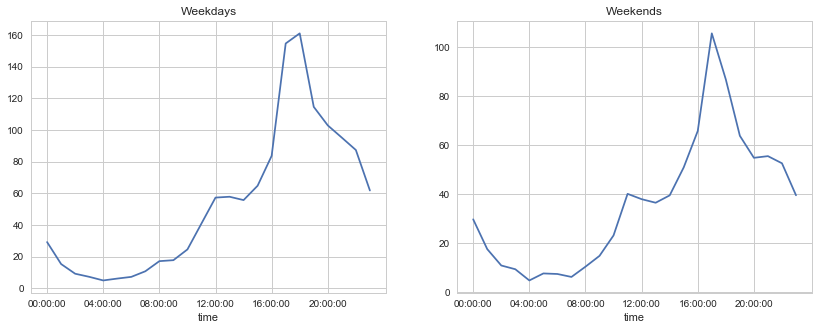

In [14]:
weekend = np.where(df1.index.weekday < 5, 'Weekday', 'Weekend')
by_time = df1.groupby([weekend, df1.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks)
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks);

What are the distribution of time period between reserve and visit?

Text(0,0.5,'count')

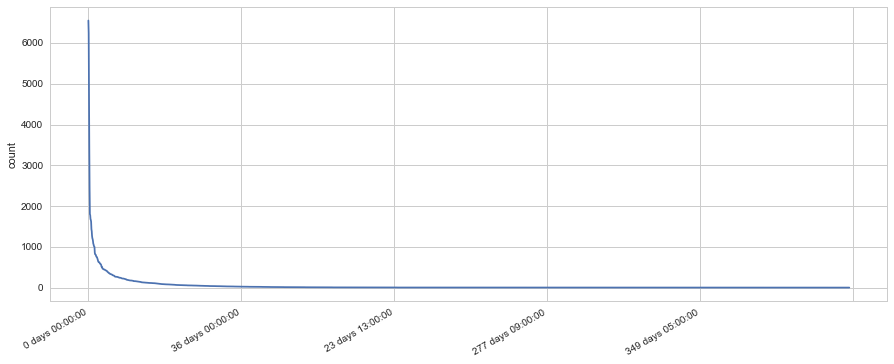

In [14]:
total_reserve['delta_reservation'].value_counts().plot()
plt.ylabel('count')

How many visitors for each time period?

Text(0,0.5,'reserve_visitors')

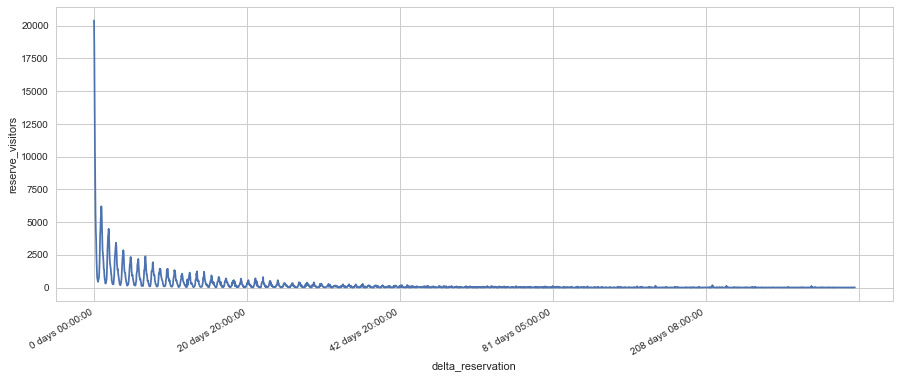

In [15]:
total_reserve.groupby('delta_reservation')['reserve_visitors'].sum().plot()
plt.ylabel('reserve_visitors')

What are the distribution of air_genre_name and air_area_name?

What is the holiday influence?

(array([0, 1]), <a list of 2 Text xticklabel objects>)

Text(0,0.5,'visitors')

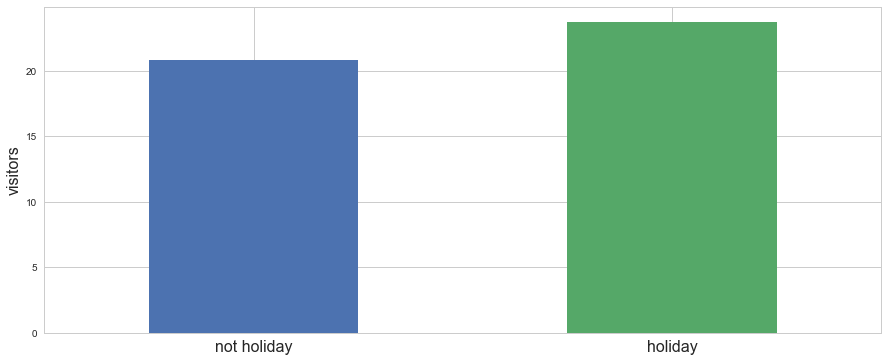

In [16]:
date_info = date_info.rename(columns = {'calendar_date':'visit_date'})
air_holiday = air_visit_data.merge(date_info, how = 'inner', on = 'visit_date')
holiday = air_holiday.groupby('holiday_flg')['visitors'].mean()
holiday.index = ['not holiday', 'holiday']
holiday.plot(kind = 'bar')
plt.xticks(rotation = 'horizontal', fontsize = 16)
plt.ylabel('visitors', fontsize =16)

Seems holiday has even a positive influence.

Which restaurants are similar? Cluster
K-means
plotly

Cluster EDA  ---> decide number of clusters
scatter plot
PCA/Cluster
PCA more deeply

counts per hour per restaurant

median income 
median price for the home
population
demographoic
how does sensonality affact data?
how many restaurant in the city?
Urban/Rural Area Classification

# Model Data Prepare

Initialize train and text, merge with visit date (weekday and holiday)

In [17]:
train = air_visit_data.copy()
train = train.merge(date_info, how = 'left', on = 'visit_date')
train["day_of_week"] = train["visit_date"].dt.weekday #0 is monday, 6 is Sunday
train.head()

test = sample_submission.copy()
test["air_store_id"] = test["id"].apply(lambda x: x[0:20])
test["visit_date"] = test["id"].apply(lambda x: x[21:])
test["visit_date"] = pd.to_datetime(test["visit_date"]) 
test = test.merge(date_info, how = 'left', on = 'visit_date')
test["day_of_week"] = test["visit_date"].dt.weekday

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2,0
1,air_ba937bf13d40fb24,2016-01-14,32,3,0
2,air_ba937bf13d40fb24,2016-01-15,29,4,0
3,air_ba937bf13d40fb24,2016-01-16,22,5,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,0


Merge with min/max/mean/median visit by store

In [18]:
visit_by_store = train.groupby(["air_store_id"])["visitors"].aggregate([min,max,np.median,np.mean]).reset_index()
train = train.merge(visit_by_store,how = "left", on = "air_store_id")
test = test.merge(visit_by_store,how = "left", on = "air_store_id")
train.head(3)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,min,max,median,mean
0,air_ba937bf13d40fb24,2016-01-13,25,2,0,1,61,22.0,22.782609
1,air_ba937bf13d40fb24,2016-01-14,32,3,0,1,61,22.0,22.782609
2,air_ba937bf13d40fb24,2016-01-15,29,4,0,1,61,22.0,22.782609


Merge with min/max/mean/median visit by store on same weekday

In [19]:
visit_by_store_weekly = train.groupby(["air_store_id","day_of_week"])["visitors"].aggregate([min,max,np.median,np.mean]).reset_index()
train = train.merge(visit_by_store_weekly,how = "left", on = ["air_store_id","day_of_week"], suffixes=["_all", "_weekday"])
test = test.merge(visit_by_store_weekly,how = "left", on = ["air_store_id","day_of_week"], suffixes=["_all", "_weekday"])
train.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,min_all,max_all,median_all,mean_all,min_weekday,max_weekday,median_weekday,mean_weekday
0,air_ba937bf13d40fb24,2016-01-13,25,2,0,1,61,22.0,22.782609,7,57,25.0,23.843750
1,air_ba937bf13d40fb24,2016-01-14,32,3,0,1,61,22.0,22.782609,2,54,21.0,20.292308
2,air_ba937bf13d40fb24,2016-01-15,29,4,0,1,61,22.0,22.782609,4,61,35.0,34.738462
3,air_ba937bf13d40fb24,2016-01-16,22,5,0,1,61,22.0,22.782609,6,53,27.0,27.651515
4,air_ba937bf13d40fb24,2016-01-18,6,0,0,1,61,22.0,22.782609,2,34,12.0,13.754386


Merge with reverse by date

In [20]:
reserve_by_date = total_reserve.groupby(["store_id","date"]).sum().reset_index()
reserve_by_date = reserve_by_date.rename(columns = {'store_id':'air_store_id','date':'visit_date'})
reserve_by_date["visit_date"] = pd.to_datetime(reserve_by_date["visit_date"])

train = train.merge(reserve_by_date, how = "left", on=["air_store_id","visit_date"])
test = test.merge(reserve_by_date, how = "left", on=["air_store_id","visit_date"])
train.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,min_all,max_all,median_all,mean_all,min_weekday,max_weekday,median_weekday,mean_weekday,reserve_visitors,delta_2days,delta_7days,delta_long
0,air_ba937bf13d40fb24,2016-01-13,25,2,0,1,61,22.0,22.782609,7,57,25.0,23.843750,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,3,0,1,61,22.0,22.782609,2,54,21.0,20.292308,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,4,0,1,61,22.0,22.782609,4,61,35.0,34.738462,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,5,0,1,61,22.0,22.782609,6,53,27.0,27.651515,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,0,0,1,61,22.0,22.782609,2,34,12.0,13.754386,NaN,NaN,NaN,NaN


In [21]:
print("There are {} unique restaurants in train data set, while just {} of them have reservation.".format(
    train["air_store_id"].nunique(),reserve_by_date["air_store_id"].nunique()))

There are 829 unique restaurants in train data set, while just 333 of them have reservation.


For restaurants that can have reservation, fill na with 0 (means, no reservation on that day)

In [22]:
train.loc[train["air_store_id"].isin(reserve_by_date["air_store_id"].unique()),"reserve_visitors"] = \
train[train["air_store_id"].isin(reserve_by_date["air_store_id"].unique())]["reserve_visitors"].fillna(0)

test.loc[test["air_store_id"].isin(reserve_by_date["air_store_id"].unique()),"reserve_visitors"] = \
test[test["air_store_id"].isin(reserve_by_date["air_store_id"].unique())]["reserve_visitors"].fillna(0)

For testaurants that never have reservation, fill na with -999

In [23]:
train.loc[~train["air_store_id"].isin(reserve_by_date["air_store_id"].unique()),"reserve_visitors"] = \
train[~train["air_store_id"].isin(reserve_by_date["air_store_id"].unique())]["reserve_visitors"].fillna(-999)

test.loc[~test["air_store_id"].isin(reserve_by_date["air_store_id"].unique()),"reserve_visitors"] = \
test[~test["air_store_id"].isin(reserve_by_date["air_store_id"].unique())]["reserve_visitors"].fillna(-999)

# Modeling

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [25]:
Xtrain = train.drop(["visitors","air_store_id","visit_date","delta_7days"],axis=1)
Xtrain = Xtrain.fillna(-999)
Ytrain = train["visitors"]

Xtest = test.drop(["id","visitors","air_store_id","visit_date","delta_7days"],axis=1)
Xtest = Xtest.fillna(-999)

In [26]:
train_x, test_x, train_y, test_y = \
train_test_split(Xtrain, Ytrain, random_state=1026, test_size=0.2)

In [27]:
def rmsle(y, yp): 
    """
    Compute the Root Mean Squared Log Error for hypthesis yp and targets y
    Args:
        yp - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log1p(yp) - np.log1p(y)).mean())

acc_scorer = make_scorer(score_func = rmsle, greater_is_better = False)

# Linear Regression

In [118]:
import statsmodels.api as sm

In [206]:
def linear_reg(train_x,train_y,test_x): 
    x = sm.add_constant(train_x, has_constant='add')
    est = sm.OLS(train_y, x)
    est = est.fit()
    lm_summary = est.summary()
    pred_x = sm.add_constant(test_x, has_constant='add')
    pred_y= est.predict(pred_x)
    return (lm_summary,pred_y)

In [207]:
lm_summary,pred_testy = linear_reg(train_x,train_y,test_x)
rmsle(test_y,pred_testy)

0.5349050651862041

## linear regression final result

In [146]:
lm_summary,pred_y = linear_reg(Xtrain,Ytrain,Xtest)
sample_submission["visitors"] = pred_y
sample_submission["visitors"] = sample_submission["visitors"].apply(lambda x: 0 if x<0 else x)
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.099238
1,air_00a91d42b08b08d9_2017-04-24,21.189447
2,air_00a91d42b08b08d9_2017-04-25,23.075842
3,air_00a91d42b08b08d9_2017-04-26,26.876391
4,air_00a91d42b08b08d9_2017-04-27,28.611301


In [143]:
sample_submission.to_csv("../output/lm1.csv",index=False)

# Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
def random_forest(train_x,train_y,test_x,**kwargs):
    forest = RandomForestRegressor(**kwargs)
    forest.fit(train_x, train_y)
    pred_y = forest.predict(test_x)
    return forest,pred_y

def plot_rf_importance(forest):
    imp = pd.DataFrame( 
    forest.feature_importances_  , 
    columns = [ 'Importance' ] , 
    index = train_x.columns)
    
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )

grid search to find optimal parameters for random forest

In [33]:
acc_scorer = make_scorer(score_func = rmsle, greater_is_better = False)
model = RandomForestRegressor()
parameters = {'n_estimators': [50,60], 
              'max_features': ['log2', 'sqrt','auto'], #The number of features to consider when looking for the best split
              'max_depth': [3, 5, 10], 
              'min_samples_split': [2, 3, 5],
             }
grid_obj = GridSearchCV(model, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(test_x, test_y)
parms = grid_obj.best_params_
parms
#grid_obj.best_score_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 60}

0.5263122151432635

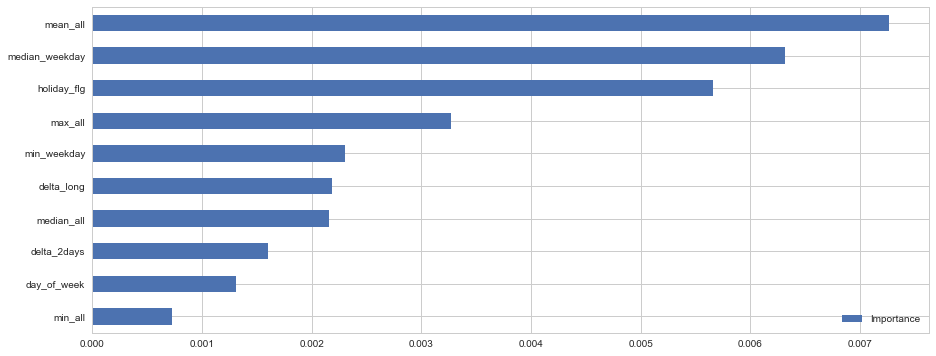

In [32]:
forest, pred_testy = random_forest(train_x,train_y,test_x,**parms)
rmsle(test_y,pred_testy)
plot_rf_importance(forest)

## Random forest final result

In [35]:
forest, pred_y = random_forest(Xtrain,Ytrain,Xtest,**parms)
sample_submission["visitors"] = pred_y
sample_submission["visitors"] = sample_submission["visitors"].apply(lambda x: 0 if x<0 else x)
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.009557
1,air_00a91d42b08b08d9_2017-04-24,20.573762
2,air_00a91d42b08b08d9_2017-04-25,23.444297
3,air_00a91d42b08b08d9_2017-04-26,27.120910
4,air_00a91d42b08b08d9_2017-04-27,29.414499


In [37]:
sample_submission.to_csv("../output/rf2.csv",index=False)

# XGBoost

In [175]:
import xgboost as xgb

C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [219]:
def opt_num_boost_round(train_x,train_y,xgb_params):
    dtrain = xgb.DMatrix(train_x, train_y)
    cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=200, early_stopping_rounds=100,
        verbose_eval=20, show_stdv=False)
    cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
    
def xgb_model(train_x,train_y,test_x,xgb_params,num_round):
    dtrain = xgb.DMatrix(train_x, train_y)
    xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_round)
    pred = xgb_model.predict(xgb.DMatrix(test_x))
    return xgb_model,pred

[0]	train-rmse:25.4082	test-rmse:25.4134
[20]	train-rmse:13.6315	test-rmse:13.7638
[40]	train-rmse:11.1187	test-rmse:11.3749
[60]	train-rmse:10.6945	test-rmse:11.023
[80]	train-rmse:10.6035	test-rmse:10.9793
[100]	train-rmse:10.5702	test-rmse:10.9726
[120]	train-rmse:10.5477	test-rmse:10.9741
[140]	train-rmse:10.5345	test-rmse:10.9773
[160]	train-rmse:10.5223	test-rmse:10.9804
[180]	train-rmse:10.5106	test-rmse:10.9823


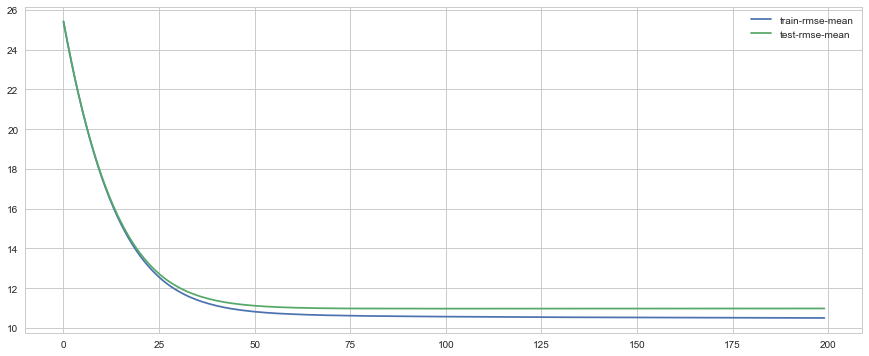

In [184]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

opt_num_boost_round(train_x,train_y,xgb_params)

In [185]:
pred_testy = xgb_model(train_x,train_y,test_x,xgb_params,60)
rmsle(test_y,pred_testy)

0.5196354966482392

## XGBoost final result

In [186]:
pred_y = xgb_model(Xtrain,Ytrain,Xtest,xgb_params,60)
sample_submission["visitors"] = pred_y
sample_submission["visitors"] = sample_submission["visitors"].apply(lambda x: 0 if x<0 else x)
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.210022
1,air_00a91d42b08b08d9_2017-04-24,19.903069
2,air_00a91d42b08b08d9_2017-04-25,22.702095
3,air_00a91d42b08b08d9_2017-04-26,26.485523
4,air_00a91d42b08b08d9_2017-04-27,28.022711


In [187]:
sample_submission.to_csv("../output/xgb2.csv",index=False)

In [188]:
from sklearn.cross_validation import KFold

In [244]:
def cv_rmsle (k,model,Xtrain,Ytrain,**kwargs):
    error = []
    n = Xtrain.shape[0]
    kf = KFold(n, n_folds = k, shuffle=True)
    #loop through K fold
    for i, (train_index, test_index) in enumerate(kf):#get the train and test index generated by Kfold
        x_tr = Xtrain.iloc[train_index] #xtrain for a fold
        y_tr = Ytrain.iloc[train_index] #ytrain for a fold
        x_te = Xtrain.iloc[test_index]  #xtest for a fold
        y_te = Ytrain.iloc[test_index]  #ytest for a fold
        
        #predict and calculate rmsle
        __, pred_yte = globals()[model](x_tr,y_tr,x_te,**kwargs)
        error.append(rmsle(y_te,pred_yte))
        print("finish {} round of {}, rmlse = {}".format(i,model,rmsle(y_te,pred_yte)))
    return error

In [246]:
k = 5
model = "linear_reg"
error = cv_rmsle(k, model, Xtrain,Ytrain)

finish 0 round of linear_reg, rmlse = 0.5314624357003316
finish 1 round of linear_reg, rmlse = 0.5354645236850739
finish 2 round of linear_reg, rmlse = 0.5362603823008182
finish 3 round of linear_reg, rmlse = 0.5368049090650254
finish 4 round of linear_reg, rmlse = 0.5352185406054286


In [242]:
k = 2
model = "xgb_model"
model_params = {
   "xgb_params": xgb_params,
    "num_round": 60
}
error = cv_rmsle(k, model, Xtrain,Ytrain,**model_params)
error

0.5204517626364877
0.518266049543694


[0.5204517626364877, 0.518266049543694]

## Times Series Model Notes
- Need to make sure data is stationary (there is no upward or downward trend). Test stationarity using Dicky-Fuller Test (sample Codes as below). In our case, we should figure out a way to asjust for the two huge gaps.

- ARIMA model: https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/


In [10]:
# Dicky Fuller Test
'''
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
'''

"\n# difference data\nmonths_in_year = 12\nstationary = difference(X, months_in_year)\nstationary.index = series.index[months_in_year:]\n# check if stationary\nresult = adfuller(stationary)\nprint('ADF Statistic: %f' % result[0])\nprint('p-value: %f' % result[1])\nprint('Critical Values:')\nfor key, value in result[4].items():\n    print('\t%s: %.3f' % (key, value))\n"